# Effect of using thresholds with softmax

This notebook shows the effect of choosing thresholds for the softmax layer in classification problems.

The usual approach is to choose the maximum of the predicted probabilities:

... code here <<<<<<<<

However, this gloses over the fact that sometimes two or more classes have very close predicted probabilities.

Using the MNIST dataset, we will investigate the effect of settings thresholds to make predictions, instead of simply the maximum probability.

Sources:

- [Tensorflow MNIST example](https://www.tensorflow.org/datasets/keras_example)
- [Keras MNIST example](https://keras.io/examples/vision/mnist_convnet/)
- [Multi-label vs. Multi-class Classification: Sigmoid vs. Softmax](https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)
- [Interpreting logits: sigmoid vs softmax](https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax.html)

In [39]:
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

To increase reproducibility (but still not guaranteed to get exactly the same results because of parallelism and GPU usages).

References:

- [Stackoverflow](https://stackoverflow.com/a/53760258)
- Tensorflow `set_seed`](https://www.tensorflow.org/api_docs/python/tf/random/set_seed)

In [2]:
SEED=1234
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load MNIST and create the training/test pipelines

The code in this section is from the [TensorFlow MNIST example](https://www.tensorflow.org/datasets/keras_example).

Load MNIST.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Build training pipeline.

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

Build test pipeline.

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Train a model

The model is a simple network of dense layers that can achieve about 98% accuracy in less than one minute of training.

This accuracy is enough for the experiments. We are interested in the effect of using different thresholds with softmax, not on very high accuracy for the model.

In [6]:
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28)
ACTIVATION='relu'

In [13]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), 
#     activation=ACTIVATION, input_shape=INPUT_SHAPE, padding='same'),
#   tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
#     padding='valid'),
#   tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), 
#     activation=ACTIVATION, padding='valid'),
#   tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2),
#     padding='valid'),
#   tf.keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1),
#     activation=ACTIVATION, padding='valid'),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(84, activation=ACTIVATION),
#   tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
  tf.keras.layers.Dense(512, activation=ACTIVATION),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation=ACTIVATION),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

Use early stopping to get a decent model without investing too much time in training. The main purspose of this notebook is not to get high accuracy. It's to demonstrate the effect of softmax thresholds.

In [14]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True)

model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
    callbacks=[callback]
)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.5445 - sparse_categorical_accuracy: 0.8276 - val_loss: 0.1280 - val_sparse_categorical_accuracy: 0.9589
Epoch 2/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1589 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.0934 - val_sparse_categorical_accuracy: 0.9712
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.0932 - val_sparse_categorical_accuracy: 0.9736
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.9687 - val_loss: 0.0804 - val_sparse_categorical_accuracy: 0.9754
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0930 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.0766 - val_sparse_categorical_accuracy: 0.9771
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0883 - sparse_categorica

## Analyze predictions on the test set

The actual labels and images 
from the test set.

In [70]:
test_label = np.concatenate([y for _, y in ds_test], axis=0)
test_image = np.concatenate([x for x, _ in ds_test], axis=0)

The predicted probabilities and labels (using the maximum predicted probability).

In [71]:
predicted_probability = model.predict(ds_test)
predicted_label = np.argmax(predicted_probability, axis=1)

# Basic sanity checks
assert len(test_label) == len(predicted_label)

Visualize some digits that were predicted correclty.

In [72]:
def draw_one_digit(ax, digit_index, digit_images, title=None):
    """Draw the image of a digit, given its index into an array of images."""
    ax.axis('off')
    ax.imshow(digit_images[digit_index], cmap=plt.get_cmap('Greys'))
    # Show the predicted class at the top
    ax.set_title(title)
    # Show the index in the test dataset on the left side, rotated to save space on multiple plots
    ax.text(0, 0, digit_index, rotation=90)

In [116]:
# Inspired by https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e
import math

def draw_digits(digit_indices):
    """ Draw digits selected from the test dataset, given their indices."""
    number_of_digits = len(digit_indices)

    f, ax = plt.subplots(1, number_of_digits, figsize=(8, 8))
    for c in range(number_of_digits):
        digit_index = digit_indices[c]
        title = "Pred. {}".format(predicted_label[digit_index])
        draw_one_digit(ax[c], digit_index, test_image, title)
    plt.tight_layout()
    plt.show()

In [112]:
# Get indices of all instaces correctly classified
correct_index = [i for i in np.arange(len(predicted_label)) 
                    if predicted_label[i] == test_label[i]]

# Get indices of all misclassfied instaces
misclassified_index = [i for i in np.arange(len(predicted_label)) 
                        if predicted_label[i] != test_label[i]]

# Sanity check
assert (len(correct_index) + len(misclassified_index)) == len(test_label)

print('Found {} correctly classified and {} misclassified instances'.format(
    len(correct_index), len(misclassified_index)))

Found 9807 correctly classified and 193 misclassified instances


Samples of correctly classified digits.

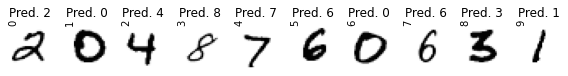

In [117]:
draw_digits(correct_index[:10])

Samples of misclassified digits (the predicted label is shown above each digit).

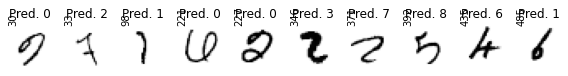

In [118]:
draw_digits(misclassified_index[:10])

## Correctly classified, by a small margin

When choosing a class, we have so far simply asked for the maximum probability:

`predicted_label = np.argmax(predicted_probability, axis=1)`

For example, here are the probabilities for one of the digits in the test set:

In [90]:
SAMPLE_DIGIT = 0
print(predicted_probability[SAMPLE_DIGIT])

[2.9643244e-18 7.3779156e-11 9.9999976e-01 2.5838185e-07 1.6679910e-14
 1.7534700e-13 1.6335948e-16 5.3463339e-10 1.1153145e-11 4.8594982e-17]


And here is what `argmax` returns:

In [91]:
np.argmax(predicted_probability[SAMPLE_DIGIT])

2

The model predicted that this the digit 2.

Here is the image, showing a 2, thus this was a correct prediction.

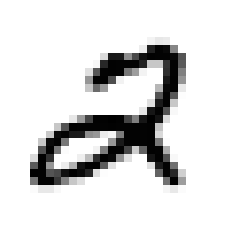

In [92]:
plt.imshow(test_images[SAMPLE_DIGIT], cmap=plt.get_cmap('Greys'))
plt.axis('off');

In this case, the model is certain that this is a digit 2 by an order of magnitude.

Here are the probabilities again. Notice the exponentials for the index 2 in the array (first index in Python = 0).

In [93]:
print(predicted_probability[SAMPLE_DIGIT])

[2.9643244e-18 7.3779156e-11 9.9999976e-01 2.5838185e-07 1.6679910e-14
 1.7534700e-13 1.6335948e-16 5.3463339e-10 1.1153145e-11 4.8594982e-17]


But we also have cases where the "winning" prediction does not have such a large margin.

In [73]:
from matplotlib.ticker import NullFormatter

def draw_prediction_histogram(ax, class_probabilities, hide_y_labels):
    """Draw a histogram of the predicted probabilities for each class and format for easier reading."""
    classes = np.arange(NUM_CLASSES)
    
    # Show all graphs in the same scale, to allow comparison
    ax.set_ylim(0, 100)

    # Draw the bars and show the class (digit) above each one
    bars = ax.bar(classes, class_probabilities*100) # Show in % (nicer labels for the y axis)
    for digit, bar in zip(classes, bars):
        yval = bar.get_height()
        ax.text(bar.get_x() - 0.25, yval + 3, digit)

    # Remove all tick marks, the bottom labels (already show class above the bar) and suppress
    # the y label for zero on the left corner to avoid confusion with the class - also zero
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks([])
    ax.set_yticks([25, 50, 75, 100])
    
    # Hide the y axis label if so requested (to make it look cleaner, show y labels only for
    # the first graph [left] in the row)
    if hide_y_labels:
        ax.yaxis.set_major_formatter(NullFormatter())

    # Show faint grid lines behind the bars
    ax.yaxis.grid(color='grey', alpha=0.25)
    ax.set_axisbelow(True)
    
    # Leave only the bottom spine visible, so the bars aren't "floating in space"
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)